In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,precision_score,recall_score,f1_score, precision_recall_curve
from sklearn import metrics
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# Load data
df = pd.read_csv("pivoted_financial_data.csv")

# Create new features (example: growth rate for total income)
# Avoid division by zero
df["Income_Growth"] = np.where(df["Total income_1"] == 0, 0, 
                               (df["Total income_11"] - df["Total income_1"]) / df["Total income_1"])

df["Profit_Growth"] = np.where(df["Profit after tax_1"] == 0, 0, 
                               (df["Profit after tax_11"] - df["Profit after tax_1"]) / df["Profit after tax_1"])

# Select key features for feature vector (example selection, adjust as needed)
features = [
    "Total income_11", "Sales_11", "Net sales_11", "Profit after tax_11",
    "Sales / Net fixed assets_11", "Cash to current liabilities (times)_11", "Income_Growth", "Profit_Growth"
]
X = df[features]
y = df["Label"]

# Split the dataset with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [3]:
def print_metrics(y_test,y_pred,clf):
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='macro')
    recall = recall_score(y_test,y_pred, average='macro')
    f1 = f1_score(y_test,y_pred, average='macro')
    print(f"For the {clf} Classifier: \n")
    print(f"Accuracy : {accuracy: .4f}")
    print(f"Precision : {precision : .4f}")
    print(f"Recall : {recall : .4f}")
    print(f"F1 Score : {f1 : .4f}")
    
    precision,recall,thresholds = precision_recall_curve(y_test,y_pred)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.plot(recall,precision,marker = '.', label = 'P-R Curve')
    plt.legend()
    plt.show()

In [4]:
def print_confusion_matrix(clf,y_test,y_pred):
    cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
    normalized_cnf_matrix = cnf_matrix.astype('float')/cnf_matrix.sum(axis = 1)[:,np.newaxis]
    # cnf_matrix
    plt.figure(figsize = (12,8))
    sns.heatmap(cnf_matrix, annot = True, fmt = '.2f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"The Confusion Matrix for the {clf} Classifier")
    plt.show()
    # normalized_cnf_matrix
    plt.figure(figsize = (12,8))
    sns.heatmap(normalized_cnf_matrix, annot = True, fmt = '.2f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"The Normalized Confusion Matrix for {clf} Classifier: ")

In [5]:
# Build a pipeline: scaling -> SMOTE -> classifier (RandomForest example)
pipeline_rf = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning
param_grid_rf = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__class_weight": [None, "balanced"]
}

In [10]:
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring="f1", n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
print("Best Params (RF):", grid_search_rf.best_params_)

Best Params (RF): {'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}


For the Random Forest Classifier: 

Accuracy :  0.7970
Precision :  0.5190
Recall :  0.7123
F1 Score :  0.4849


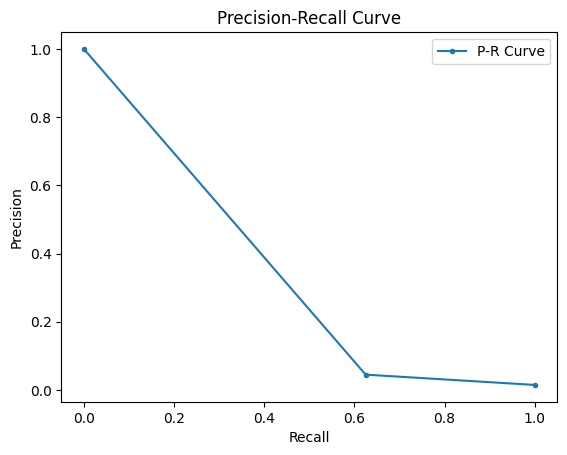

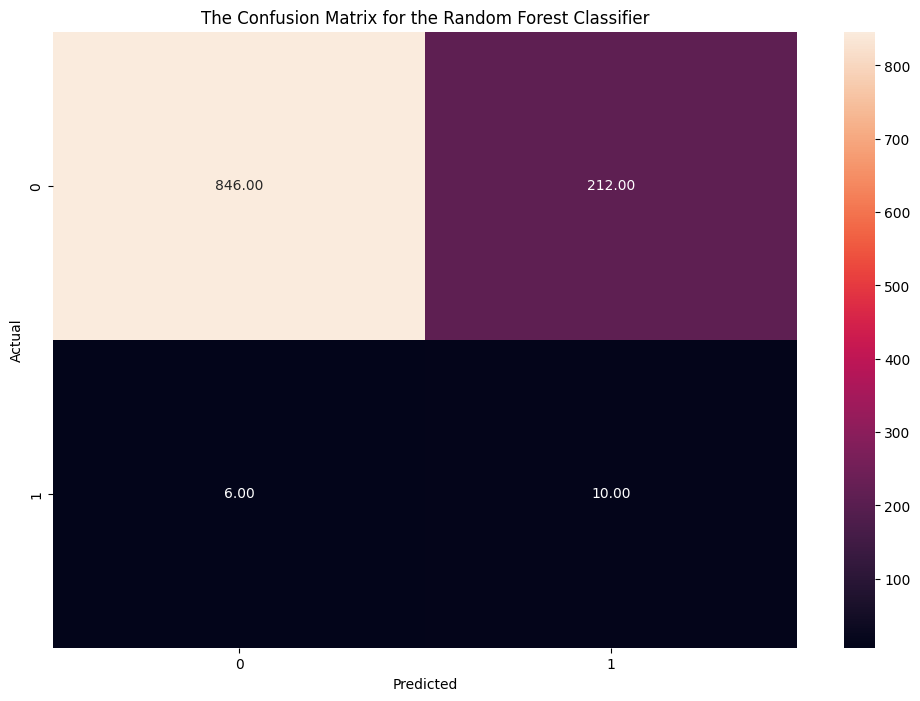

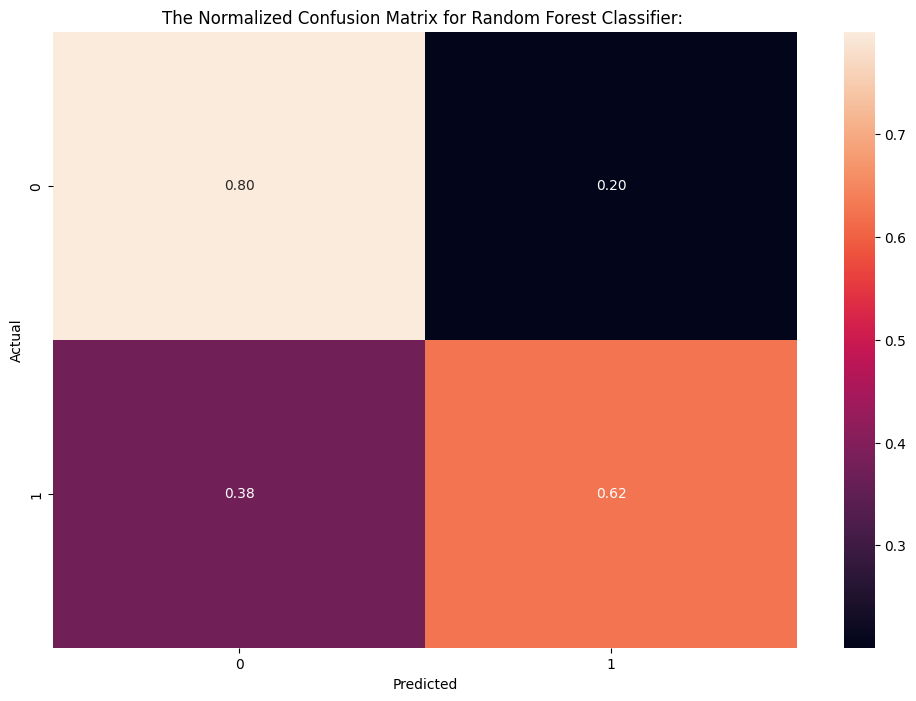

In [13]:
# Evaluate on test set
y_pred_rf = grid_search_rf.predict(X_test)
print_metrics(y_test,y_pred_rf, "Random Forest")
print_confusion_matrix("Random Forest",y_test,y_pred_rf)

In [14]:
pipeline_svm = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("classifier", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42))
])

param_grid_svm = {
    "classifier__C": [0.1, 1, 10],
    "classifier__gamma": [0.001, 0.01, 0.1]
}

In [15]:
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring="f1", n_jobs=-1)
grid_search_svm.fit(X_train, y_train)
print("Best Params (SVM):", grid_search_svm.best_params_)

Best Params (SVM): {'classifier__C': 10, 'classifier__gamma': 0.1}


For the SVM's Classifier: 

Accuracy :  0.4004
Precision :  0.5102
Recall :  0.6649
F1 Score :  0.3038


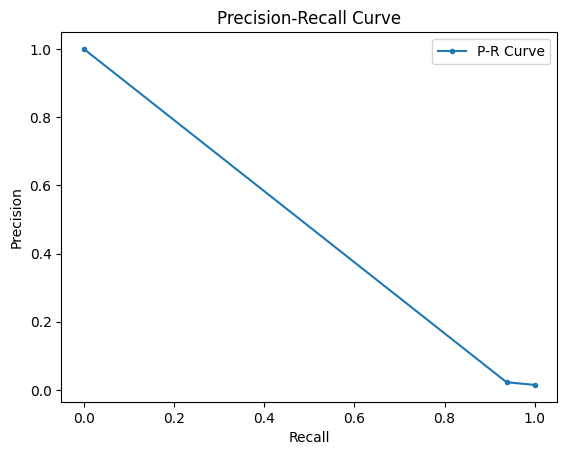

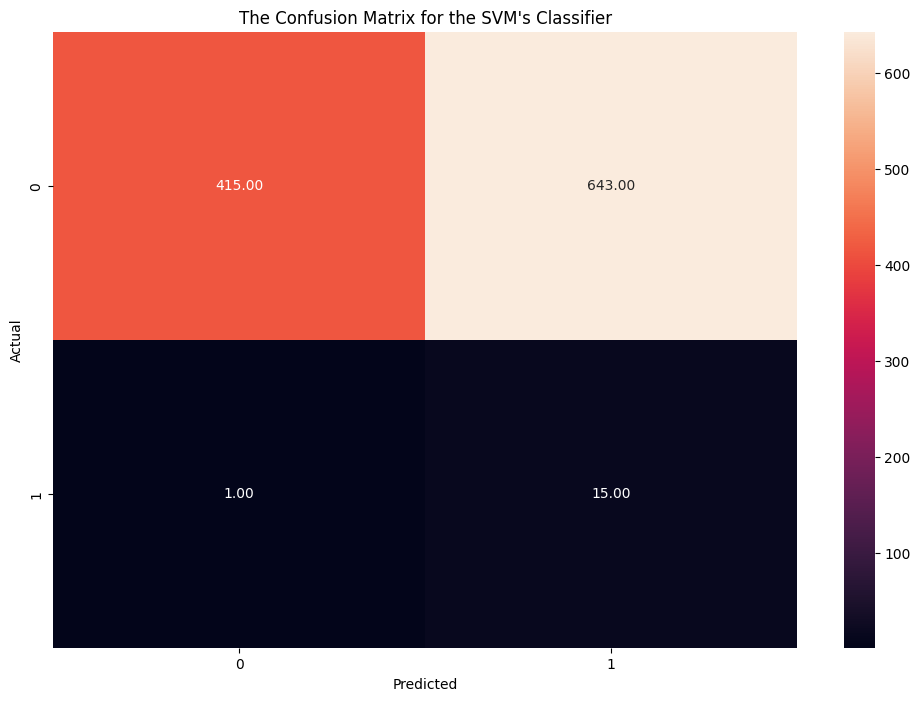

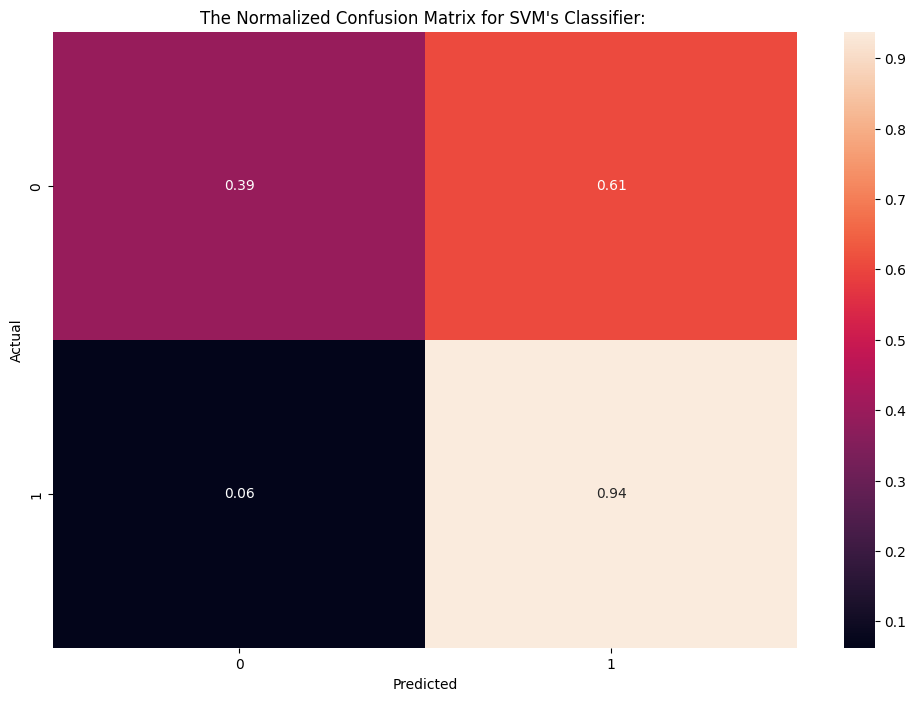

In [16]:
# Evaluate SVM
y_pred_svm = grid_search_svm.predict(X_test)
print_metrics(y_test,y_pred_svm, "SVM's")
print_confusion_matrix("SVM's",y_test,y_pred_svm)